In [45]:
import pandas as pd
import numpy as np
import warnings
from glob import glob
import os
from sklearn.metrics import confusion_matrix
import scikitplot as skplt
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.metrics import accuracy_score, f1_score

import torch
import torch.nn as nn
from pytorch_tabnet.tab_model import TabNetClassifier
from pytorch_tabnet.multitask import TabNetMultiTaskClassifier
from keras.utils import to_categorical
from tensorflow.python.keras.utils import np_utils

%matplotlib inline
# !pip install pytorch-tabnet

In [3]:
# file load & merge
directory_path = './final_prpdata_1st/'
file_names = [f for f in os.listdir(directory_path) if f.endswith('.csv')]
file_names = sorted(file_names)
file_names

['df_prp_f_0.csv',
 'df_prp_f_1.csv',
 'df_prp_f_2.csv',
 'df_prp_f_3.csv',
 'df_prp_f_4.csv',
 'df_prp_f_5.csv',
 'df_prp_f_6.csv',
 'df_prp_f_7.csv']

In [4]:
# file load & merge
directory_path = './final_prpdata_1st/'
file_names = [f for f in os.listdir(directory_path) if f.endswith('.csv')]
file_names = sorted(file_names)
dataframes = [pd.read_csv(os.path.join(directory_path, file_name)) for file_name in file_names]
df_prpdata_all = pd.concat(dataframes, ignore_index=True)
# f_mode 컬럼 추가
df_best50 = df_prpdata_all.copy()
conditions = [
    (df_best50['hpt_yn'] == 1) & (df_best50['lpt_yn'] == 0) & (df_best50['fan_yn'] == 0) & (df_best50['hpc_yn'] == 0) & (df_best50['lpc_yn'] == 0),
    (df_best50['hpt_yn'] == 1) & (df_best50['lpt_yn'] == 1) & (df_best50['fan_yn'] == 0) & (df_best50['hpc_yn'] == 0) & (df_best50['lpc_yn'] == 0),
    (df_best50['hpt_yn'] == 0) & (df_best50['lpt_yn'] == 0) & (df_best50['fan_yn'] == 1) & (df_best50['hpc_yn'] == 0) & (df_best50['lpc_yn'] == 0),
    (df_best50['hpt_yn'] == 0) & (df_best50['lpt_yn'] == 0) & (df_best50['fan_yn'] == 0) & (df_best50['hpc_yn'] == 1) & (df_best50['lpc_yn'] == 0),
    (df_best50['hpt_yn'] == 0) & (df_best50['lpt_yn'] == 0) & (df_best50['fan_yn'] == 0) & (df_best50['hpc_yn'] == 1) & (df_best50['lpc_yn'] == 1),
    (df_best50['hpt_yn'] == 0) & (df_best50['lpt_yn'] == 1) & (df_best50['fan_yn'] == 0) & (df_best50['hpc_yn'] == 0) & (df_best50['lpc_yn'] == 0),
    (df_best50['hpt_yn'] == 1) & (df_best50['lpt_yn'] == 1) & (df_best50['fan_yn'] == 1) & (df_best50['hpc_yn'] == 1) & (df_best50['lpc_yn'] == 1),
    (df_best50['hpt_yn'] == 0) & (df_best50['lpt_yn'] == 0) & (df_best50['fan_yn'] == 0) & (df_best50['hpc_yn'] == 0) & (df_best50['lpc_yn'] == 0),
]
failurMode = ['hpt', 'hpt+lpt', 'fan', 'hpc', 'hpc+lpc', 'lpt', 'all', 'healthy']
df_best50["f_mode"] = np.select(conditions, failurMode, default='None')

In [6]:
featureNamesBest50WANOVA =['climb_hpt_hpc_press_mean',
 'climb_hpt_hpc_press_ratio_mean',
 'climb_hpt_entry_press_ratio_mean',
 'climb_RUL',
 'climb_hpt_hpc_press_min',
 'climb_hpt_hpc_press_ratio_max',
 'cruise_hpt_entry_temp_drop_mean',
 'climb_hpt_entry_press_ratio_max',
 'climb_hpt_entry_temp_drop_mean',
 'cruise_hpt_hpc_press_mean',
 'cruise_hpt_entry_press_ratio_mean',
 'cruise_hpt_hpc_press_ratio_mean',
 'climb_hpt_hpc_temp_mean',
 'climb_hpt_hpc_temp_ratio_mean',
 'cruise_hpt_entry_press_ratio_max',
 'cruise_hpt_hpc_press_min',
 'cruise_hpt_hpc_press_ratio_max',
 'cruise_SmHPC_mean',
 'climb_hpt_entry_press_ratio_min',
 'climb_hpt_hpc_press_ratio_min',
 'climb_hpt_hpc_press_max',
 'climb_fan_exit_press_min',
 'climb_P50_std',
 'climb_hpt_entry_temp_drop_min',
 'climb_SmHPC_mean',
 'climb_SmFan_mean',
 'climb_SmLPC_max',
 'climb_Mach_std',
 'climb_hpc_lpc_temp_max',
 'climb_hpc_lpc_temp_ratio_max',
 'climb_alt_min',
 'cruise_hpt_hpc_temp_ratio_mean',
 'cruise_hpt_hpc_temp_mean',
 'climb_T30_max',
 'climb_hpt_hpc_temp_max',
 'climb_P2_std',
 'cruise_SmLPC_mean',
 'climb_hpt_entry_temp_drop_max',
 'climb_P21_std',
 'climb_P15_std',
 'cruise_hpt_entry_temp_drop_min',
 'climb_W22_std',
 'climb_W25_std',
 'climb_W31_std',
 'climb_W32_std',
 'climb_W50_std',
 'climb_W48_std',
 'climb_P40_std',
 'climb_P30_std',
 'climb_Ps30_std']

add_featureNamesBest50WANOVA = featureNamesBest50WANOVA.copy()
# add_featureNamesBest50WANOVA.append('fileNo')
add_featureNamesBest50WANOVA.append('unit')
add_featureNamesBest50WANOVA.append('cycle')

In [7]:
ds01_test_unitNo = ((df_best50.fileNo == 0) & (df_best50.unit.isin([7,8,9,10])))
ds02_test_unitNo = ((df_best50.fileNo == 1) & (df_best50.unit.isin([11,14,15])))
ds03_test_unitNo = ((df_best50.fileNo == 2) & (df_best50.unit.isin([10,11,12,13,14,15])))
ds04_test_unitNo = ((df_best50.fileNo == 3) & (df_best50.unit.isin([7,8,9,10])))
ds05_test_unitNo = ((df_best50.fileNo == 4) & (df_best50.unit.isin([7,8,9,10])))
ds06_test_unitNo = ((df_best50.fileNo == 5) & (df_best50.unit.isin([7,8,9,10])))
ds07_test_unitNo = ((df_best50.fileNo == 6) & (df_best50.unit.isin([7,8,9,10])))
ds08a_test_unitNo = ((df_best50.fileNo == 7) & (df_best50.unit.isin([10,11,12,13,14,15])))
ds08c_test_unitNo = ((df_best50.fileNo == 8) & (df_best50.unit.isin([7,8,9,10])))

# 데이터 준비
train_set = df_best50.loc[~(ds01_test_unitNo | ds02_test_unitNo | ds03_test_unitNo | ds04_test_unitNo | ds05_test_unitNo | ds06_test_unitNo | ds07_test_unitNo | ds08a_test_unitNo | ds08c_test_unitNo)]
test_set = df_best50.loc[(ds01_test_unitNo | ds02_test_unitNo | ds03_test_unitNo | ds04_test_unitNo | ds05_test_unitNo | ds06_test_unitNo | ds07_test_unitNo | ds08a_test_unitNo | ds08c_test_unitNo)]

train_set = train_set.loc[train_set.unit != 0]
test_set = test_set.loc[test_set.unit != 0]

# print(train_set.f_mode.value_counts())
# print(test_set.f_mode.value_counts())

c:\Users\admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\pytorch_tabnet\abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


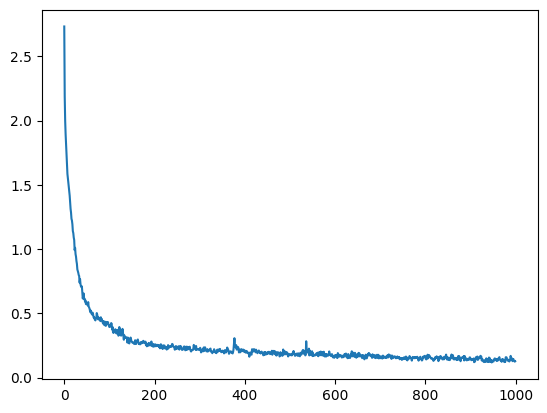

In [135]:
# TabNetMultiTaskClassifier 

X_full_train = train_set.drop('f_mode', axis=1)[add_featureNamesBest50WANOVA].reset_index(drop=True)
y_full_train = train_set['f_mode'].reset_index(drop=True)
X_full_test = test_set.drop('f_mode', axis=1)[add_featureNamesBest50WANOVA].reset_index(drop=True)
y_full_test = test_set['f_mode'].reset_index(drop=True)

# 데이터 전처리_Scaling 준비
scaler = MinMaxScaler()
scaler.fit(X_full_train[featureNamesBest50WANOVA])
encoder = LabelEncoder()
encoder.fit(y_full_train)

X_train_scaled = scaler.transform(X_full_train[featureNamesBest50WANOVA])
y_train_encoded = encoder.transform(y_full_train)
X_test = scaler.transform(X_full_test[featureNamesBest50WANOVA])
y_test = encoder.transform(y_full_test)

y_train_reshape = y_train_encoded.reshape(len(y_train_encoded), 1) # 1차원 -> 2차원으로 변경

#  eval_metric=accuracy, balanced_accuracy, logloss
tnmt_clf = TabNetMultiTaskClassifier(seed=42, verbose=False)
tnmt_clf.fit(X_train_scaled, y_train_reshape, drop_last = False, patience=10, max_epochs=1000, eval_metric=['accuracy'])

# X_train, X_val, y_train, y_val = train_test_split(X_train_scaled, y_train_encoded, test_size=0.2, random_state=42, stratify=y_train_encoded)
# tn_clf.fit(X_train, y_train, eval_set=[(X_val, y_val)], drop_last = False, patience=10, max_epochs=1000, eval_metric=['accuracy'])
plt.plot(tnmt_clf.history['loss'])

accuracy: 0.8626721250465202
f1: 0.862055367133552


<Axes: title={'center': 'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

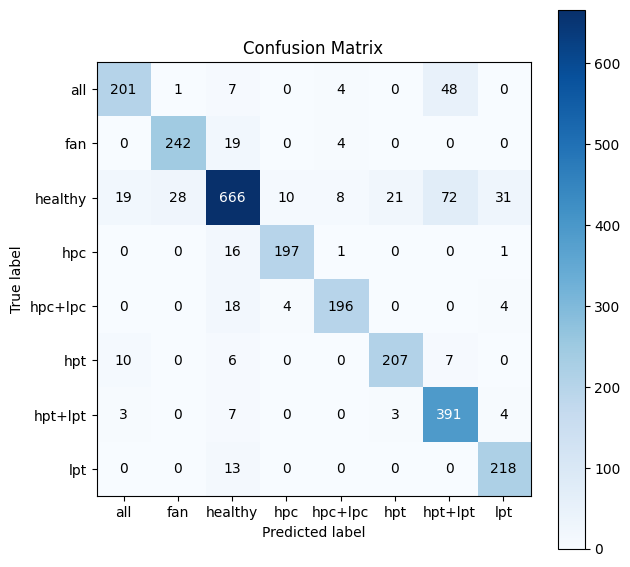

In [137]:
tnmt_pred = tnmt_clf.predict(X_test)
tnmt_pred = tnmt_pred[0].astype(int)

f1 = f1_score(y_test, tnmt_pred, average='weighted')
accuracy = accuracy_score(y_test, tnmt_pred)
print(f"accuracy: {accuracy}")
print(f"f1: {f1}")

skplt.metrics.plot_confusion_matrix(encoder.inverse_transform(y_test), encoder.inverse_transform(tnmt_pred), figsize=(7,7))